In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
import statsmodels

In [229]:
df = pd.read_excel("System_combined.xlsx")
df.set_index("DateTime", inplace=True)
df.sort_index(ascending=True)
df = df.drop("Unnamed: 0", axis = 1)
df['systemPrice'].interpolate(method='time', inplace=True)
df.isna().sum()

systemPrice    0
dtype: int64

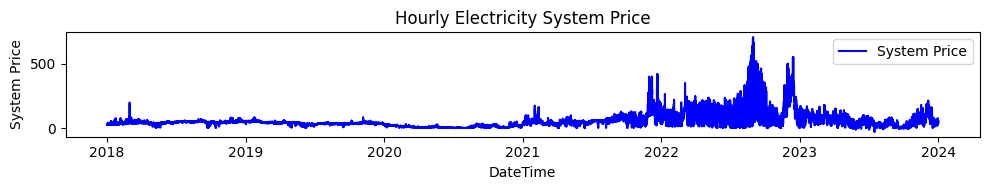

In [5]:
# Plotting
plt.figure(figsize=(10, 2))  # Optional: Adjust figure size
plt.plot(df.index, df['systemPrice'], label='System Price', color='blue')  # Plot systemPrice
plt.title('Hourly Electricity System Price')  # Title
plt.xlabel('DateTime')  # X-axis label
plt.ylabel('System Price')  # Y-axis label
plt.legend()  # Show legend
plt.tight_layout()  # Optional: Adjust layout to make room for labels

# To show the plot if not automatically displayed
plt.show()


## Tests for stationarity 

In [6]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print('Results of Augmented Dickey-Fuller Test:')
    adf_result = adfuller(timeseries)
    
    # Retrieve the p-value
    adf_pvalue = adf_result[1]
    
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_pvalue}')
    
    if adf_pvalue < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print('\nResults of KPSS Test:')
    statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    
    # As the p-value is approximate, it should not be taken as an absolute measure of stationarity.
    if p_value < 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")



In [7]:

adf_test(df["systemPrice"]) #h0 can be rejected, there is  enough evidence that the timeseries is stationary
kpss_test(df["systemPrice"]) #h0 can be rejected, there is enough evidence that the timeseries is non-statinoary

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -9.577550489049926
p-value: 2.2025769433108786e-16
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 8.876045258727991
p-value: 0.01
The series is non-stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_11452\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


<Axes: xlabel='DateTime'>

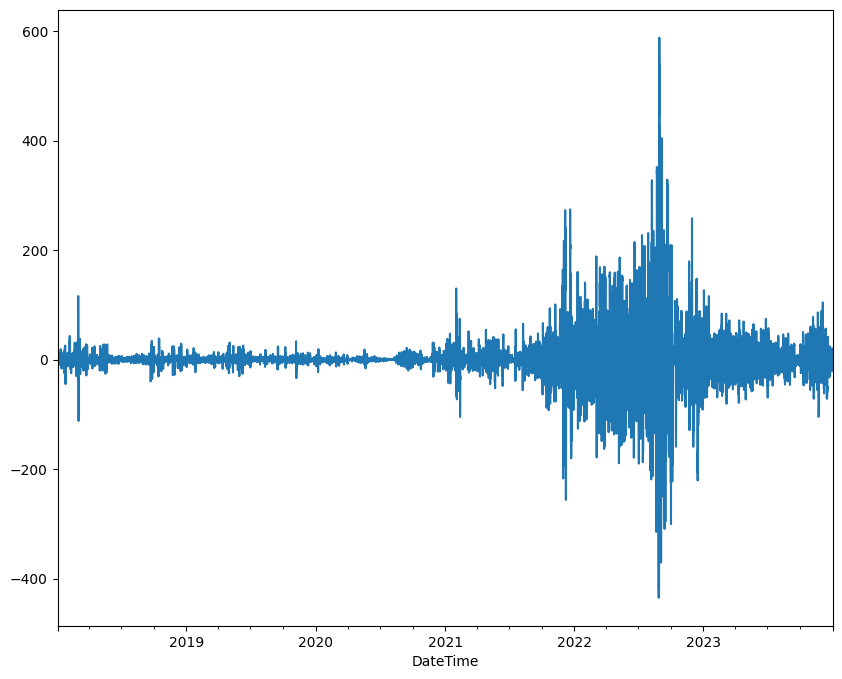

In [8]:
df["systemPrice_diff"] = df["systemPrice"] - df["systemPrice"].shift(24)
df["systemPrice_diff"].dropna().plot(figsize=(10,8))

In [9]:
#Checking Stationary again after detrending
adf_test(df["systemPrice_diff"].dropna()) #stationary as pvalue : 0
kpss_test(df["systemPrice_diff"].dropna()) #non-stationory as pvalue : 0.1


Results of Augmented Dickey-Fuller Test:
ADF Statistic: -34.44441604352567
p-value: 0.0
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.004718572063466152
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_11452\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


# Finding Parameters for ARIMA

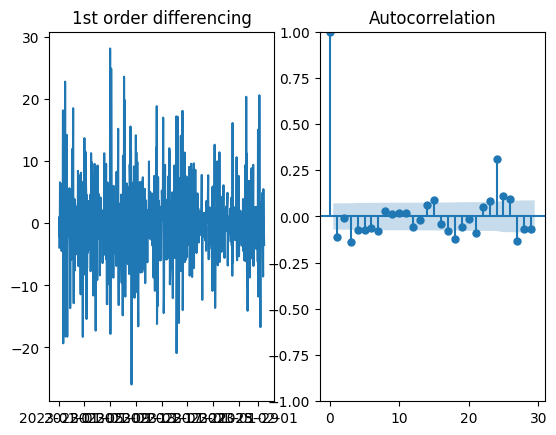

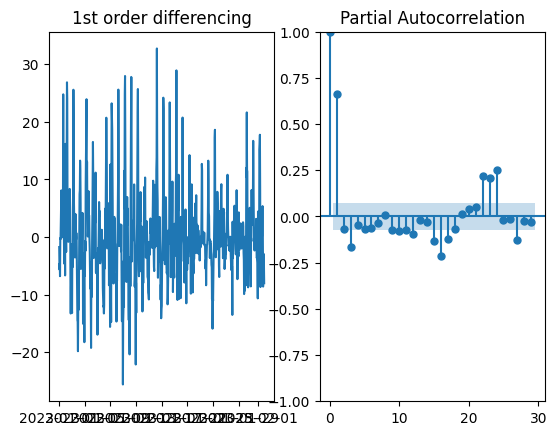

In [118]:
#checking out FIltered period

filtered_df = df["2023-01-01":"2023-02-01"]

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(filtered_df["systemPrice"].diff().diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(filtered_df["systemPrice"].diff().diff().dropna(), ax=ax2)
plt.show()

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(filtered_df["systemPrice"].diff().diff().dropna())

ax2 = f.add_subplot(122)
plot_pacf(filtered_df["systemPrice"].diff().diff().dropna(), ax=ax2)
plt.show()

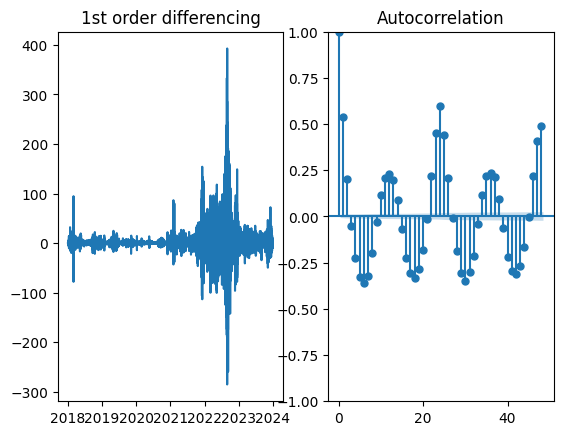

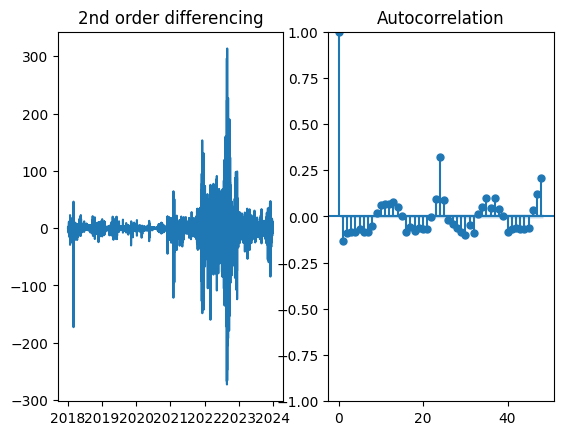

In [31]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(df["systemPrice"].diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(df["systemPrice"].diff().dropna(), ax=ax2)
plt.show()

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2nd order differencing")
ax1.plot(df["systemPrice"].diff().diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(df["systemPrice"].diff().diff().dropna(), ax=ax2)
plt.show()

In [119]:
result = adfuller(filtered_df["systemPrice"].dropna())
print("p-value: ", result[1])
result = adfuller(filtered_df["systemPrice"].diff().dropna())
print("p-value: ", result[1])
result = adfuller(filtered_df["systemPrice"].diff().diff().dropna())
print("p-value: ", result[1])

p-value:  0.0676347134827518
p-value:  8.031522905900152e-23
p-value:  1.8144453937213667e-29


## Trying to use the diff df and extracting seasonal component and trend being left with residuals

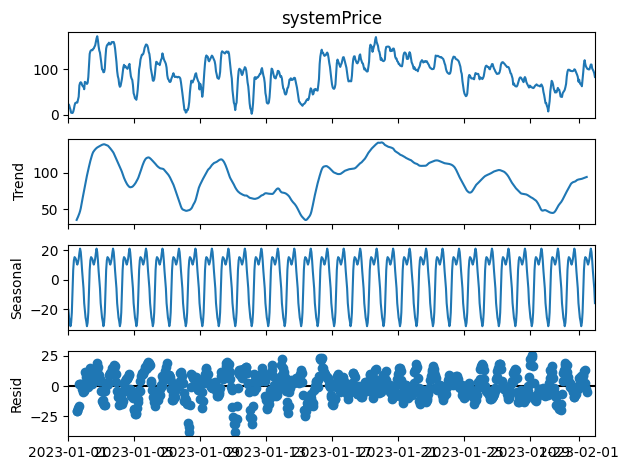

In [120]:
# Re-importing the necessary libraries as the execution state was reset.
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt

# Creating a dummy dataframe for the example as the real 'filtered_df' is not available.
# Please replace the below 'dates' and 'systemprice' with your actual datetime index and system price data.
#dates = pd.date_range(start='2020-01-01', periods=100, freq='H')
#systemprice = filtered_df["systemPrice"]  # Replace with your actual system price data.

# Creating the dataframe
#filtered_df = pd.DataFrame(data=systemprice, index=dates, columns=['systemprice'])

# Make sure that the DataFrame index is a datetime object
#filtered_df.index = pd.to_datetime(filtered_df.index)

# Decompose the time series using an additive model
# The 'freq' parameter should be set according to the seasonality of your data.
# For example, if you have daily data with a weekly cycle, you might set freq=7.
# Here we'll assume an hourly data with a daily cycle, hence freq=24.
decomposition = seasonal_decompose(filtered_df['systemPrice'], model='additive', period=224)

# This will extract the trend, seasonal, and residual components.
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
decomposition.plot()

# Show the plots
plt.show()

# The 'trend', 'seasonal', and 'residual' are now separate series that you can examine or plot as needed.
# If you want to further use these components, they are available as follows:
# decomposition.trend
# decomposition.seasonal
# decomposition.resid

# Please replace 'freq' with the appropriate frequency of your data.
# If the seasonality is not known, you may need to perform some analysis to determine it.


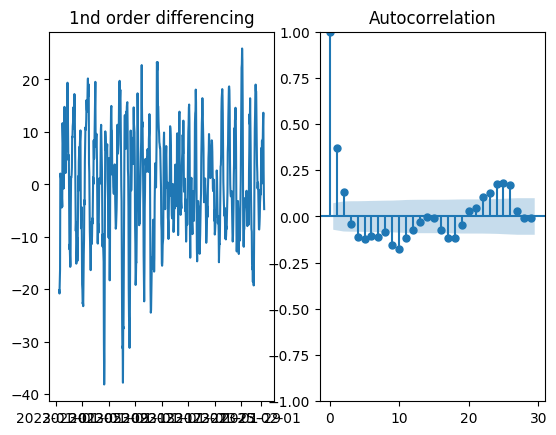

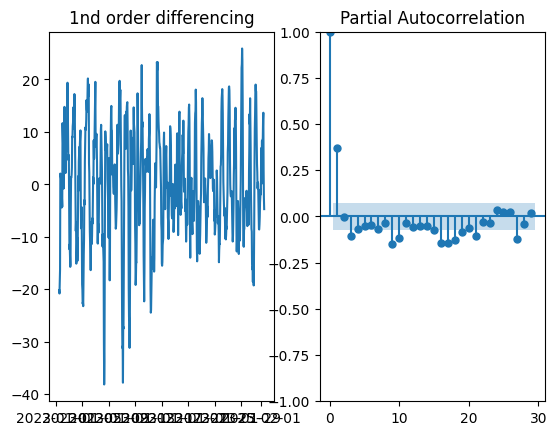

In [136]:
#f = plt.figure()
#ax1 = f.add_subplot(121)
#ax1.set_title("residuals")
#ax1.plot(residual)

#ax2 = f.add_subplot(122)
#plot_acf(residual.dropna(), ax=ax2)
#plt.show()


#f = plt.figure()
#ax1 = f.add_subplot(121)
#ax1.set_title("Residuals")
#ax1.plot(residual)

#ax2 = f.add_subplot(122)
#plot_pacf(residual.dropna(), ax=ax2)
#plt.show()


f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1nd order differencing")
ax1.plot(residual)

ax2 = f.add_subplot(122)
plot_acf(residual.diff().dropna(), ax=ax2)
plt.show()


f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1nd order differencing")
ax1.plot(residual)

ax2 = f.add_subplot(122)
plot_pacf(residual.diff().dropna(), ax=ax2)
plt.show()



In [135]:
adf_test(residual.dropna())
kpss_test(residual.dropna()) 

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -10.475734232788733
p-value: 1.250493005023591e-18
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.0112446565051624
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_11452\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')



# ARIMA New

In [155]:

# Using the to_frame() method
df = filtered_dfArima["systemPrice"].to_frame()

# Alternatively, using the DataFrame constructor
df = pd.DataFrame(filtered_dfArima["systemPrice"])
df.info()
# Using the to_frame() method

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 2023-01-01 00:00:00 to 2023-02-01 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   systemPrice  768 non-null    float64
dtypes: float64(1)
memory usage: 12.0 KB


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            systemPrice   No. Observations:                  768
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 357.273
Date:                Fri, 08 Mar 2024   AIC                           -706.546
Time:                        19:03:13   BIC                           -687.976
Sample:                    01-01-2023   HQIC                          -699.398
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3115      0.051      6.153      0.000       0.212       0.411
ma.L1          0.0131      0.057      0.229      0.819      -0.099       0.125
ma.L2          0.2831      0.029      9.861      0.0

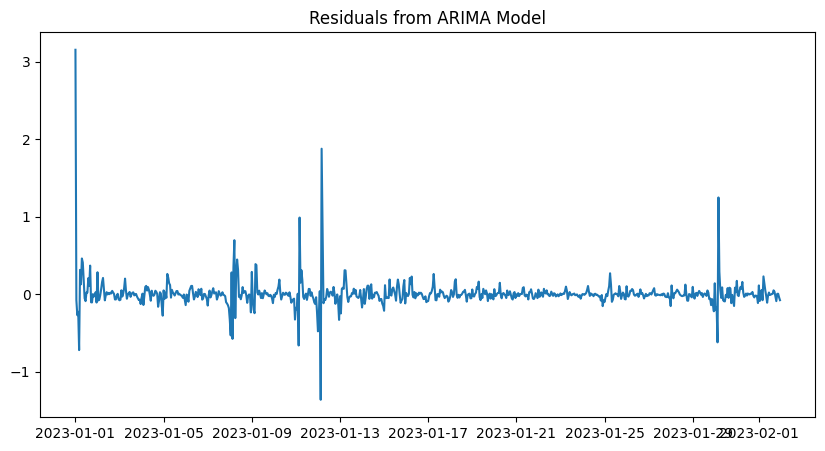

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

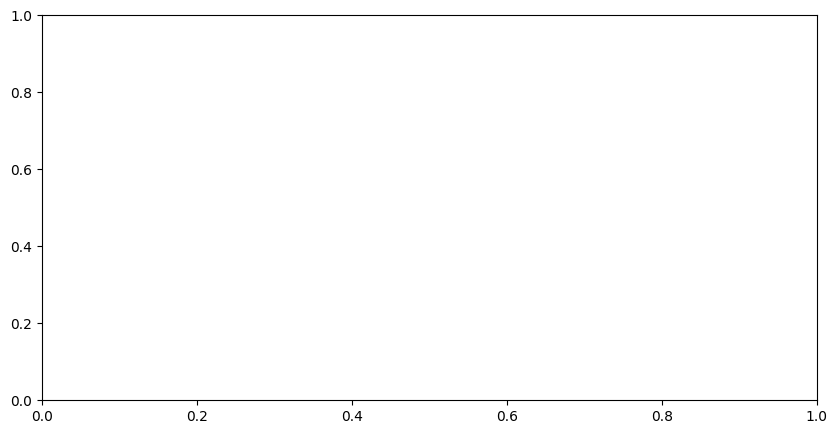

In [157]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and systemPrice is your column with time series data.

# Fit the model
model = ARIMA(np.log(df["systemPrice"]), order=(1, 1, 2)) # (P,D,Q)
model_fit = model.fit()

# Print out the ARIMA model summary
print(model_fit.summary())

# Plot the residuals to check for any patterns (should look like white noise)
residuals = model_fit.resid
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

# To plot the predictions:
fig, ax = plt.subplots(figsize=(10,5))
fig = model_fit.plot_predict(start=1, end=len(filtered_dfArima["systemPrice"]) + 12, ax=ax)
ax.set_title('Forecast vs Actual')
plt.show()


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            systemPrice   No. Observations:                  768
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 357.273
Date:                Fri, 08 Mar 2024   AIC                           -706.546
Time:                        19:22:20   BIC                           -687.976
Sample:                    01-01-2023   HQIC                          -699.398
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3115      0.051      6.153      0.000       0.212       0.411
ma.L1          0.0131      0.057      0.229      0.819      -0.099       0.125
ma.L2          0.2831      0.029      9.861      0.0

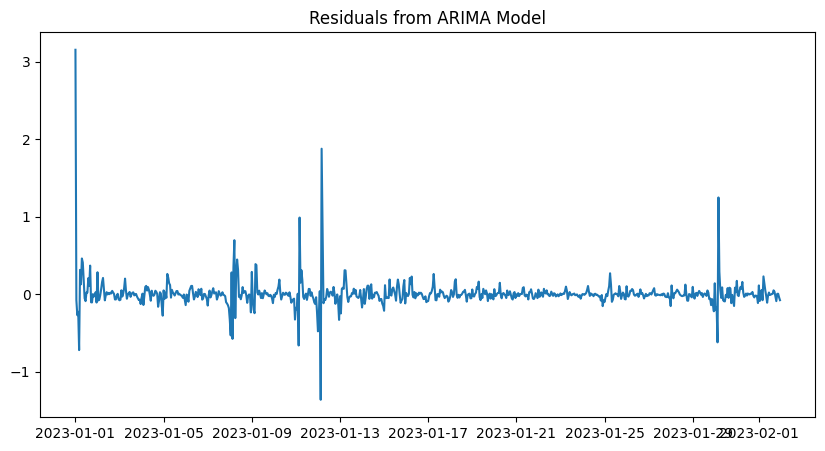

In [198]:
filtered_dfArima = df["2023-01-01":"2023-12-31"]

model = ARIMA(np.log(filtered_dfArima["systemPrice"]), order=(1, 1, 2)) # (P,D,Q) # Example order, should be determined by ACF/PACF analysis
model_fit = model.fit()

# Print out the ARIMA model summary
print(model_fit.summary())

# Plot the residuals to check for any patterns (should look like white noise)
residuals = model_fit.resid
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

In [230]:
filtered_dfArima = df["2023-01-01":"2023-12-31"]
train_size = int(len(filtered_dfArima) * 0.8)
train, test = filtered_dfArima[0:train_size], filtered_dfArima[train_size:len(filtered_dfArima)]


In [254]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (1, 1, 2)  # Example non-seasonal order
seasonal_order = (1, 1, 2, 24)  # Example seasonal order (with daily seasonality for hourly data)

# Fit the SARIMA model on the log-transformed data
model = SARIMAX(train['systemPrice'], order=order, seasonal_order=seasonal_order)
results = model.fit()


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


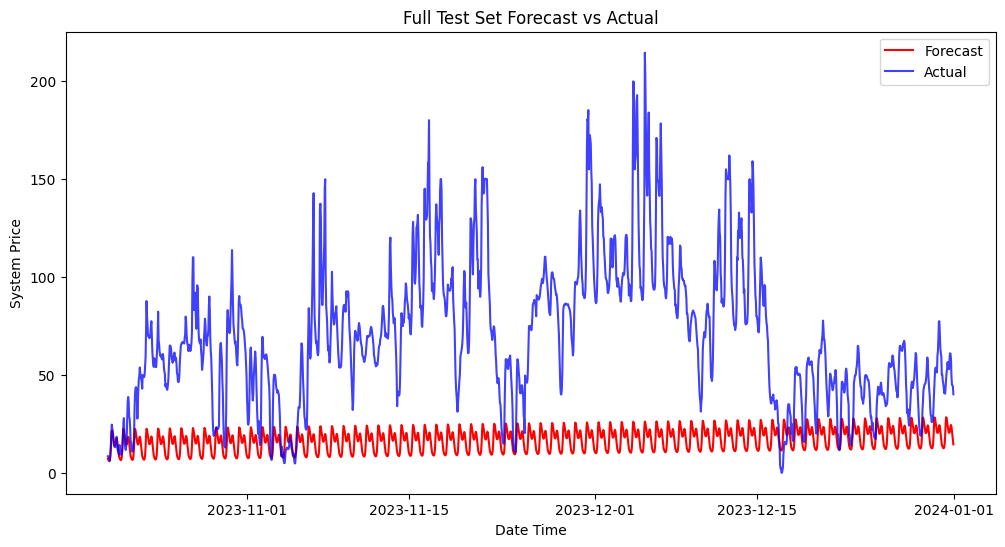

In [255]:
import matplotlib.pyplot as plt

# Forecast
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# Plot the forecast alongside the actual values for the entire test set
plt.figure(figsize=(12, 6))
plt.plot(forecast_mean, label='Forecast', color='red')
plt.plot(test['systemPrice'], label='Actual', color='blue', alpha=0.75)

plt.title('Full Test Set Forecast vs Actual')
plt.xlabel('Date Time')
plt.ylabel('System Price')
plt.legend()
plt.show()


                               SARIMAX Results                                
Dep. Variable:            systemPrice   No. Observations:                  768
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 357.273
Date:                Fri, 08 Mar 2024   AIC                           -706.546
Time:                        20:13:02   BIC                           -687.976
Sample:                    01-01-2023   HQIC                          -699.398
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3115      0.051      6.153      0.000       0.212       0.411
ma.L1          0.0131      0.057      0.229      0.819      -0.099       0.125
ma.L2          0.2831      0.029      9.861      0.0

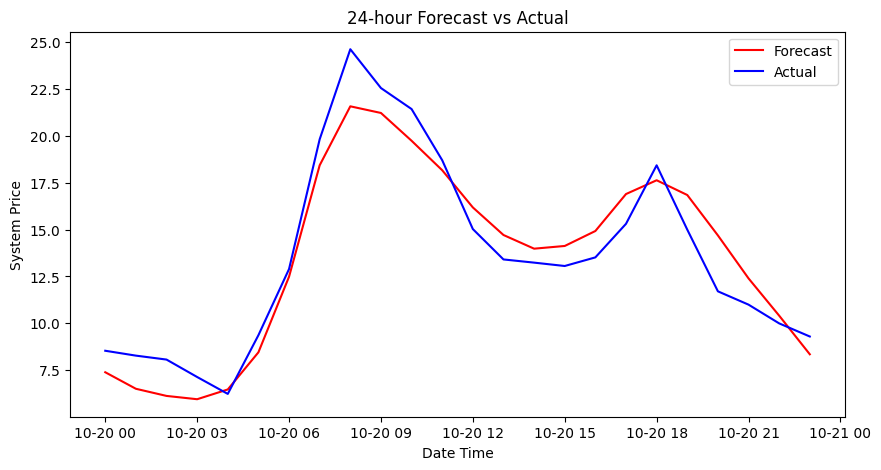

In [252]:
forecast = results.get_forecast(steps=24,)
forecast_mean_log = forecast.predicted_mean

# Revert log-transformed forecast back to original scale by exponentiation
forecast_mean = forecast_mean_log

# Select the actual values from the test set for the first 24 hours and exponentiate to revert the transformation
actuals = test['systemPrice'][:24]

print(model_fit.summary())
# Plot the forecast alongside the actual values
plt.figure(figsize=(10, 5))
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red',)
plt.plot(actuals.index, actuals, label='Actual', color='blue')

plt.title('24-hour Forecast vs Actual')
plt.xlabel('Date Time')
plt.ylabel('System Price')
plt.legend()
plt.show()

AttributeError: 'function' object has no attribute 'info'

In [251]:
# Assuming 'test' is your DataFrame with the actual test data
# Assuming that 'test' index has the same datetime format as the 'train' DataFrame

# Predicting on the test set
# The 'dynamic=False' argument ensures that we produce one-step-ahead forecasts, 
# meaning that forecasts at each point are generated using the full history up to that point
predictions = results.get_forecast(steps=len(test.index))

# The forecast gives you several attributes; we want the predicted mean
predicted_mean = predictions.predicted_mean

# If the index of predictions does not align with the test set, align it manually
predicted_mean.index = test.index

# Convert predictions and actuals to the same scale if model was trained on log-transformed data
predicted_prices = predicted_mean
actual_prices = test['systemPrice']  # assuming the test set is not log-transformed

# Now we can calculate the APE, MAPE, and RMSE
ape = np.abs((actual_prices - predicted_prices) / actual_prices) * 100
mape = np.mean(ape)
rmse = np.sqrt(np.mean((actual_prices - predicted_prices) ** 2))

# Print the results
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



Mean Absolute Percentage Error (MAPE): 87.00%
Root Mean Squared Error (RMSE): 63.70


## Yeo-Johnson Transformation to try to fix variance

                     systemPrice  systemPrice_diff  systemPrice_stationary  \
DateTime                                                                     
2018-01-01 00:00:00    26.263485               NaN                3.091290   
2018-01-01 01:00:00    26.382834               NaN                3.791328   
2018-01-01 02:00:00    26.043561               NaN                3.730293   
2018-01-01 03:00:00    24.585894               NaN                2.235357   
2018-01-01 04:00:00    24.626124               NaN                1.754048   

                     systemPrice_transformed  
DateTime                                      
2018-01-01 00:00:00                 7.227263  
2018-01-01 01:00:00                 7.245047  
2018-01-01 02:00:00                 7.194374  
2018-01-01 03:00:00                 6.972386  
2018-01-01 04:00:00                 6.978609  
Fitted Lambda: 0.4244604941006285


<Axes: xlabel='DateTime'>

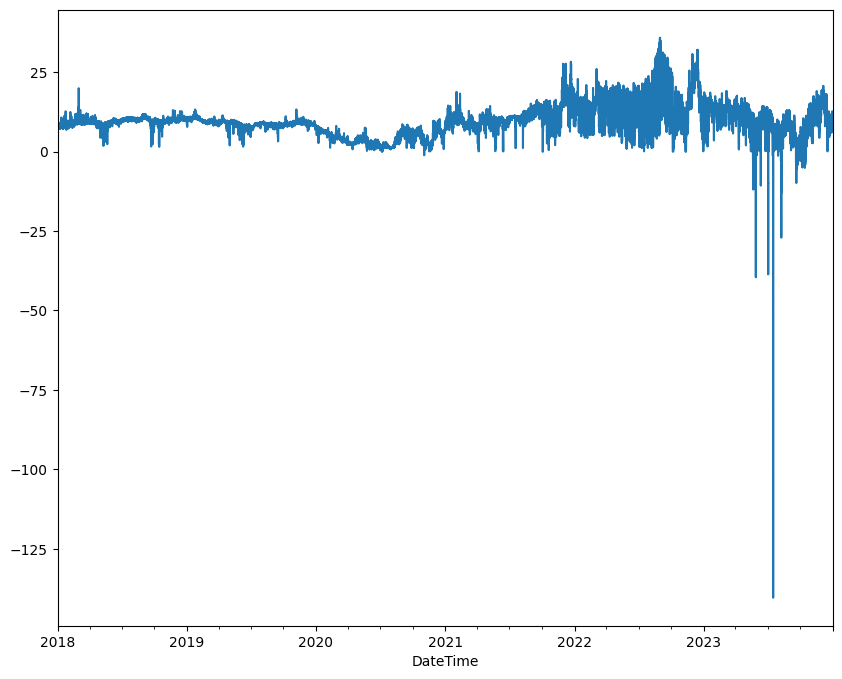

In [48]:
from scipy import stats
import pandas as pd

# Assuming you have a dataframe 'df' with a column 'systemPrice'
# df = your_actual_dataframe

# Apply the Yeo-Johnson transformation
df['systemPrice_transformed'], fitted_lambda = stats.yeojohnson(df['systemPrice'])

# Display the first few rows of the dataframe to verify the transformation
print(df.head())
print('Fitted Lambda:', fitted_lambda)

df["systemPrice_transformed"].dropna().plot(figsize=(10,8))


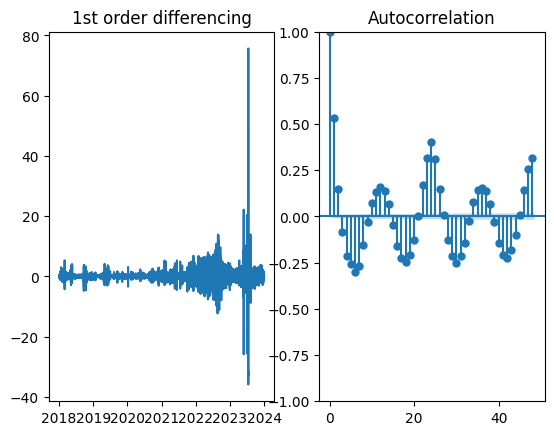

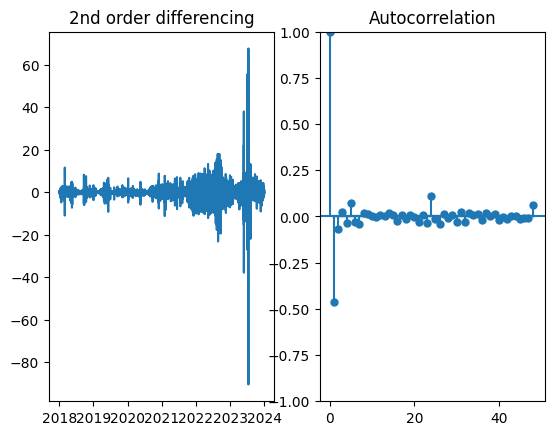

In [46]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(df['systemPrice_transformed'].diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(df['systemPrice_transformed'].diff().dropna(), ax=ax2)
plt.show()

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2nd order differencing")
ax1.plot(df['systemPrice_transformed'].diff().diff().diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(df['systemPrice_transformed'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

# STL Model

The ACF plot indicates that it still have some seasonality after detrending by shifting.Trying another approach: STL (Seasonal-Trend decomposition using Loess)

STL is flexible and allows for handling multiple seasonalities by breaking down the time series into three components:

Seasonal: Repeating short-term cycle in the series.,
Trend: Longer-term direction of the series.
Residual: The random variation left after extracting the seasonality and trend.

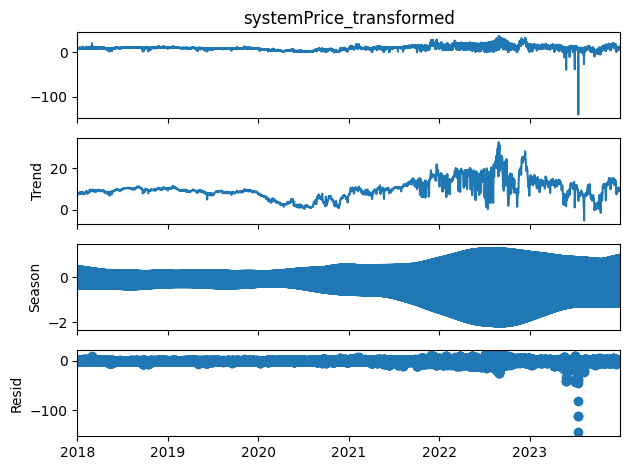

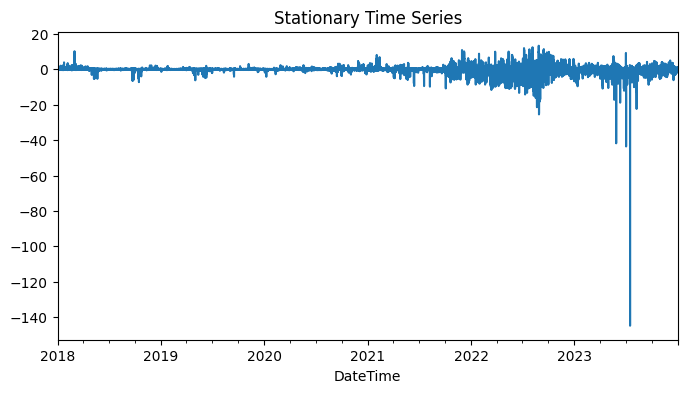

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -24.93411050695076
p-value: 0.0
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 5.055766164917401
p-value: 0.01
The series is non-stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_11452\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [98]:
#New STL Model test

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
#df["systemPrice_transformed"]
# Assuming 'df' and 'systemPrice' column setup
df.index = pd.to_datetime(df.index)

# Apply STL decomposition
#stl = STL(df["systemPrice_transformed"].dropna(), seasonal=365, period=24, robust = True)
stl = STL(df["systemPrice_transformed"].dropna(), seasonal=365, period=24, robust = True)  # Adjust 'seasonal' as needed
result = stl.fit()
result.plot()
plt.show()

# Subtract both trend and seasonal component to get residuals (stationary series)
df['systemPrice_transformed'] = result.resid

# Plot the stationary series
df['systemPrice_transformed'].dropna().plot(figsize=(8,4))
plt.title('Stationary Time Series')
plt.show()

adf_test(df['systemPrice_transformed'].dropna())
kpss_test(df['systemPrice_transformed'].dropna()) 


In [107]:
min_value = 30
constant_to_add = abs(min_value) + 1

# Add the constant to the 'systemPrice' column and take the log
filtered_df['log_systemPrice'] = np.log(filtered_df["2023-01-01":"2023-03-01"] + constant_to_add)


## STL Period Check


Results of Augmented Dickey-Fuller Test:
ADF Statistic: -10.004527857425497
p-value: 1.84646410887462e-17
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.03210961628633645
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_11452\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


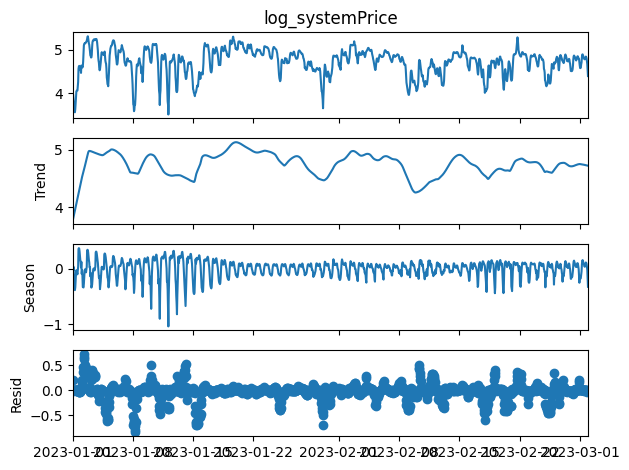

In [108]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

# Ensure the DataFrame index is recognized as a pandas datetime index
# This is crucial for proper filtering based on dates
df.index = pd.to_datetime(df.index)

# Filter the DataFrame for the specific date range
filtered_df = df["2023-01-01":"2023-03-01"]

# Apply STL decomposition to the filtered time series
stl = STL(filtered_df['log_systemPrice'], seasonal=7, period=24, robust = True)  # Assuming daily seasonality
res = stl.fit()

# Plot the decomposed components
fig = res.plot()

df['systemPrice_STL'] = res.resid

adf_test(df["systemPrice_STL"].dropna())
kpss_test(df["systemPrice_STL"].dropna()) 

In the code above, the STL function is initialized with the time series data and the period parameter is set to 24 for hourly data which indicates a daily seasonality. The seasonal parameter can be adjusted based on how smooth you want the seasonal component of your time series to be. A higher number makes the seasonal component smoother.

## continuing

In [90]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming 'residuals' is a pandas Series of numerical data containing the residuals of your STL model
# Ensure that 'residuals' are indeed floats and not strings
#residuals = residuals.astype(float)

# Apply the Ljung-Box test
lb_results = acorr_ljungbox(df["systemPrice_STL"], lags=[24], return_df=True)

# Print the results
print(lb_results)

# Check the p-value for significance
if lb_results['lb_pvalue'].iloc[0] < 0.05:
    print("The residuals are not white noise, indicating correlation in the data.")
else:
    print("The residuals are white noise, indicating no correlation.")



    lb_stat  lb_pvalue
24      NaN        NaN
The residuals are white noise, indicating no correlation.


The Ljung-Box test results indicate a very high test statistic and a p-value of 0.0 for the residuals of your STL-decomposed series. This suggests that there is strong evidence of autocorrelation in the residuals at the first 10 lags.

When the Ljung-Box test statistic is significant (as in your case, where the p-value is effectively 0), this implies that the residuals are not independently distributed, and hence, they are not white noise. This could mean that there is still some structure left in your time series data that the STL decomposition did not fully capture, or there could be other dynamics at play that have not been accounted for.

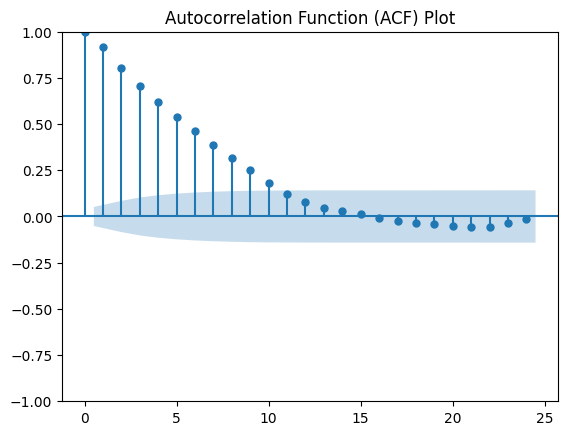

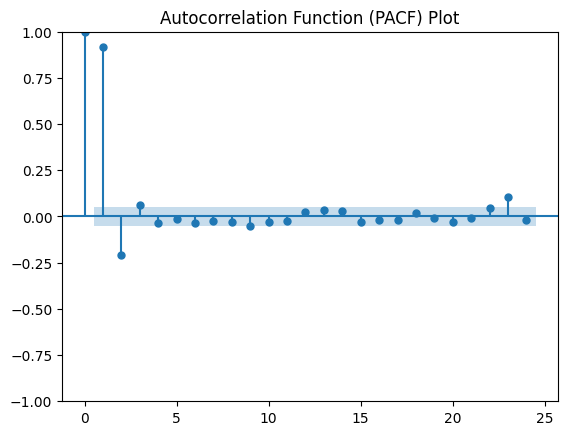

In [110]:
plot_acf(df["systemPrice_STL"].dropna(), lags=24)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

plot_pacf(df["systemPrice_STL"].dropna(), lags=24)
plt.title('Autocorrelation Function (PACF) Plot')
plt.show()



## ARIMA

ADF Statistic: -48.64293572027026
p-value: 0.0


/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     systemPrice_stationary   No. Observations:                52584
Model:                     ARIMA(0, 2, 1)   Log Likelihood             -184160.793
Date:                    Wed, 06 Mar 2024   AIC                         368325.585
Time:                            17:34:37   BIC                         368343.326
Sample:                        01-01-2018   HQIC                        368331.130
                             - 12-31-2023                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.002   -403.549      0.000      -1.005      -0.995
sigma2        64.4981      0.169    381.630      0.000      64.167      64.829
Ljung-Box (L1) (Q): 

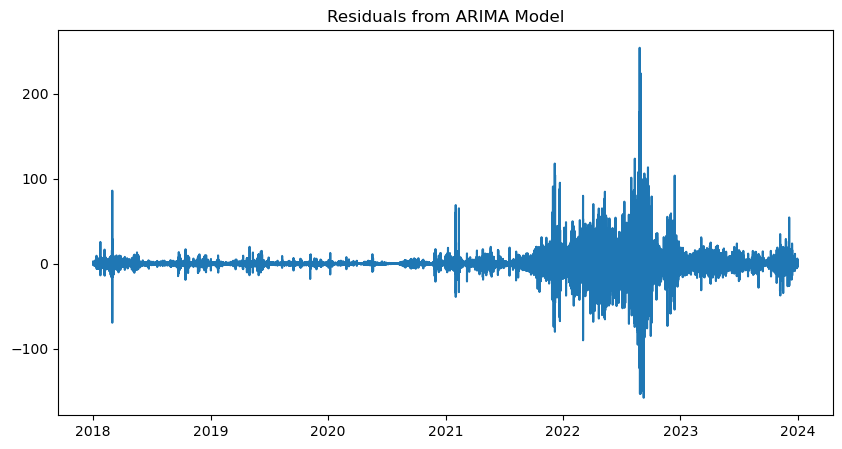

In [30]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

# Load your dataset
# Assuming 'df' is your DataFrame and 'systemPrice' is your column with time series data
# df.index = pd.to_datetime(df.index)  # Make sure the index is a datetime type
# filtered_df = df['2018-01-01':'2023-12-31']  # Filter the data for the period 2018 to 2023

# Before fitting an ARIMA model, you should ensure stationarity
# For example, run an ADF test to check stationarity
adf_result = adfuller(df['systemPrice_stationary'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# If the p-value indicates non-stationarity, you may need to difference the data
# Here, I'll proceed with the assumption that the series is stationary

# Fit an ARIMA model
# Note: You need to choose the order (p,d,q) of the ARIMA model appropriately
# p: The number of lag observations included in the model (AR)
# d: The number of times that the raw observations are differenced (I)
# q: The size of the moving average window (MA)

model = ARIMA(df['systemPrice_stationary'], order=(0, 2, 1)) # (P,D,Q) # Example order, should be determined by ACF/PACF analysis
model_fit = model.fit()

# Print out the ARIMA model summary
print(model_fit.summary())

# Plot the residuals to check for any patterns (should look like white noise)
residuals = model_fit.resid
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()


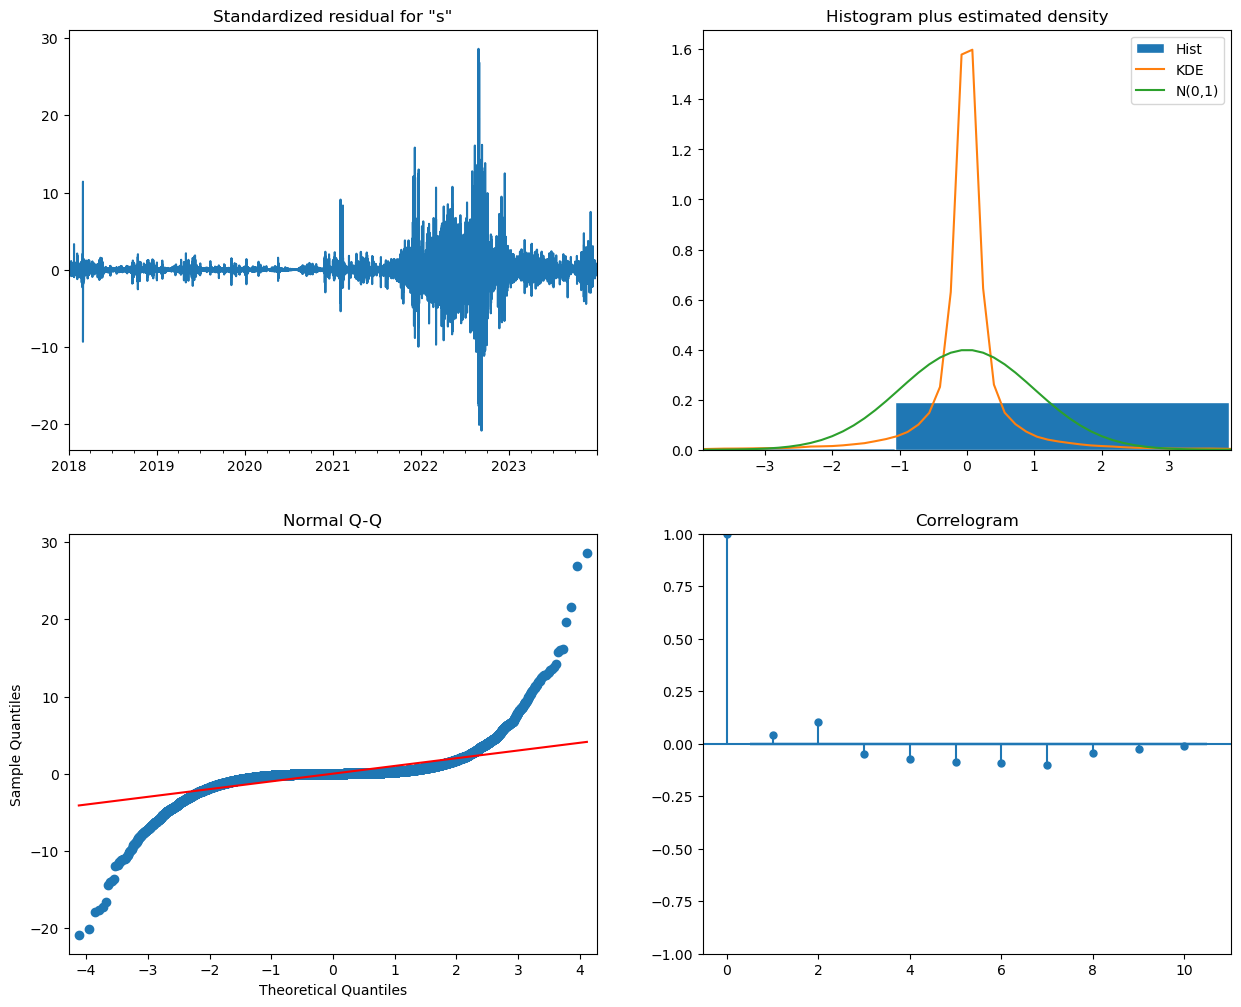

In [24]:
# Perform diagnostic checks on the model
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


In [256]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
#df = df['systemPrice_stationary']
# Assuming df is your DataFrame and the 'systemPrice' column contains your time series data
#df.index = pd.to_datetime(df.index)  # Ensure the index is datetime
#train_df = df[df.index.year < 2023]  # Data up to the end of 2022
#test_df = df[df.index.year == 2023]  # Data for 2023

# Fit an ARIMA model on the training dataset.
# The order (p, d, q) should be determined after conducting proper time series analysis.
# I'll use (1, 1, 1) as a placeholder. You should find the optimal parameters.
#model = ARIMA(train_df['systemPrice_stationary'], order=(1, 0, 1))
#model_fit = model.fit()

# Forecast for 2023
# The number of steps to forecast is the length of the test set
forecast = model_fit.get_forecast(steps=len(test_df))

# Get confidence intervals of the forecast
forecast_ci = forecast.conf_int()

# Plot the training data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_df['systemPrice_stationary'], label='Training Data')
plt.plot(test_df['systemPrice_stationary'], label='Actual Prices', color='orange')
plt.plot(forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.title('ARIMA Model Forecast for 2023')
plt.legend()
plt.show()

# Optionally, compare the forecasted values with the actual values
# This will give you a sense of the model's accuracy
comparison_df = test_df.copy()
comparison_df['forecast'] = forecast.predicted_mean

# Depending on the frequency of the data, you might want to resample it for daily, weekly, or monthly comparison
# comparison_df.resample('D').mean()  # For daily resampling
print(comparison_df)


NameError: name 'test_df' is not defined

# Seasonal Decompose Additive Model. 

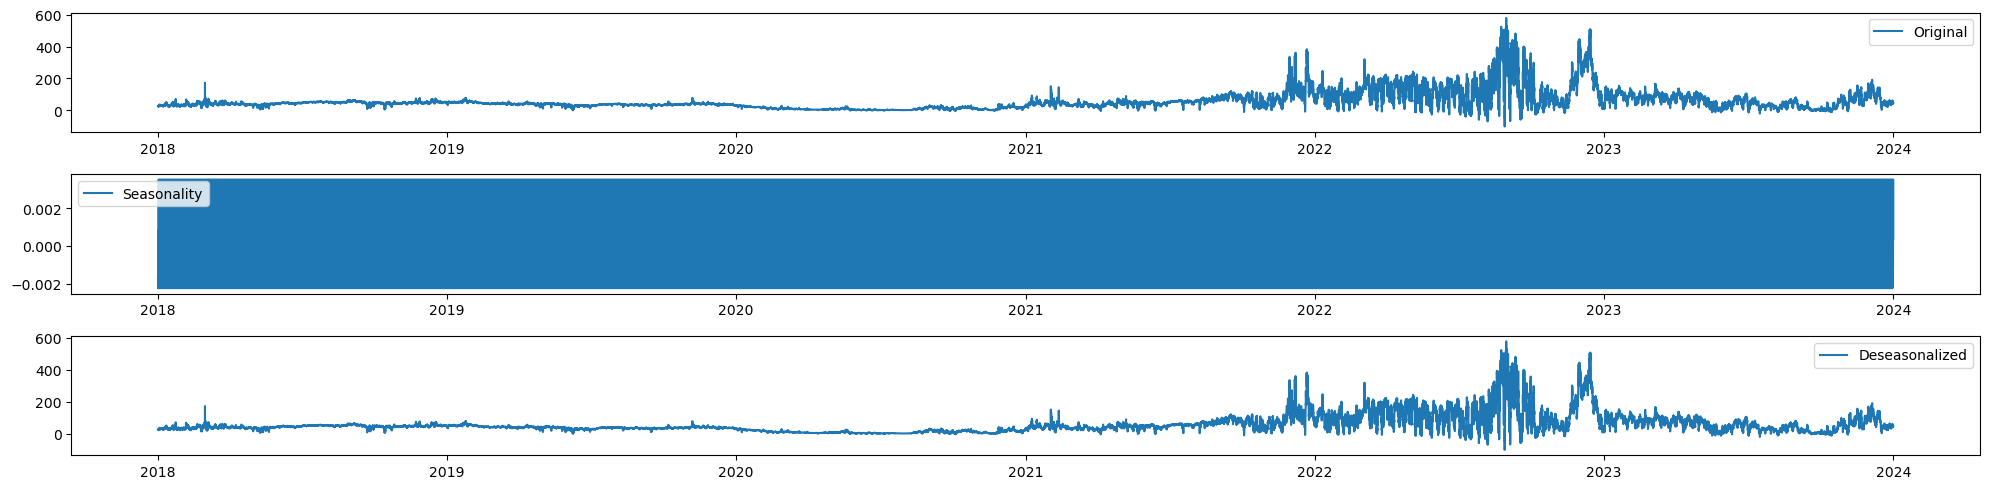

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'systemPrice' is your column with time series data
# The frequency is set to 24, which is the number of observations per day (hourly data)

decomposition = seasonal_decompose(df['systemPrice'], model='additive', period=24)

# Extract the seasonal component
seasonal_component = decomposition.seasonal

# Subtract the seasonal component from the original series to deseasonalize
df['deseasonalized'] = df['systemPrice'] - seasonal_component

# Plotting the original, seasonal, and deseasonalized data
plt.figure(figsize=(20, 5))  # Making the plot bigger
plt.subplot(311)
plt.plot(df['systemPrice'], label='Original')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(seasonal_component, label='Seasonality')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(df['deseasonalized'], label='Deseasonalized')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [37]:
adf_test(df["deseasonalized"].dropna())
kpss_test(df["deseasonalized"].dropna()) 

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -9.02332030294309
p-value: 5.697438333690716e-15
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 8.760395565374159
p-value: 0.01
The series is non-stationary.


/var/folders/cw/dgdk4x9j6fn07sqw2331qdhc0000gn/T/ipykernel_1099/4185787262.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


## Check for stationarity end

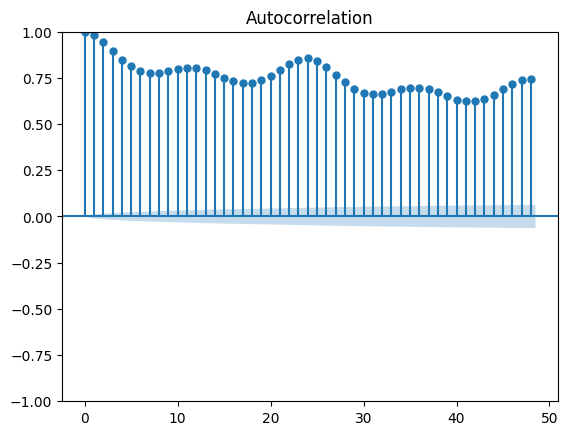

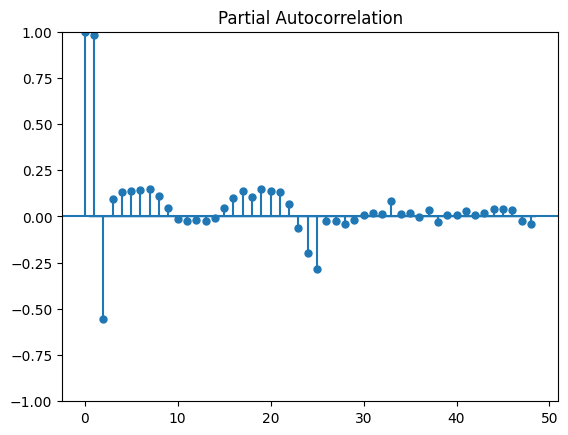

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced and seasonally differenced data
plot_acf(df["systemPrice"], lags = 48, alpha = 0.05)
plot_pacf(df["systemPrice"], lags = 48, alpha = 0.05)
plt.show()


End Testing for Stationary and making it stationary

## Differencing (detrending and deseasonalizing)

/Users/evenbakke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


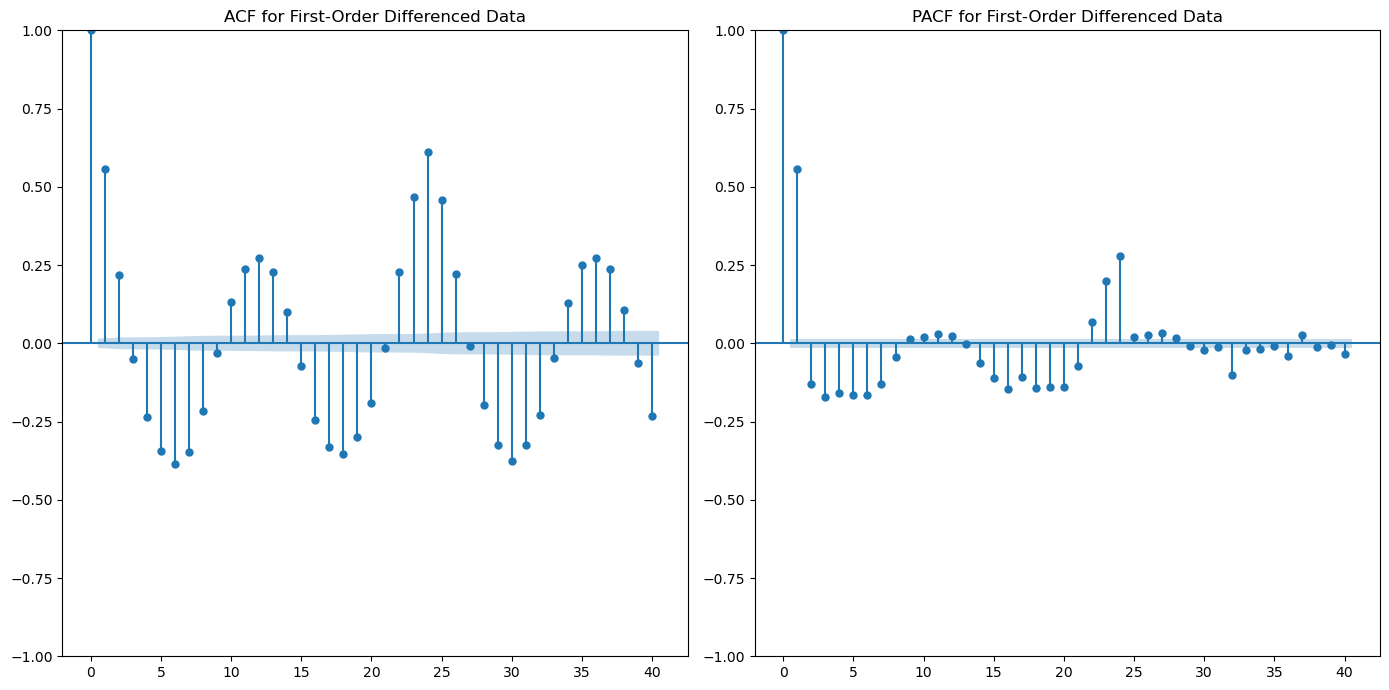

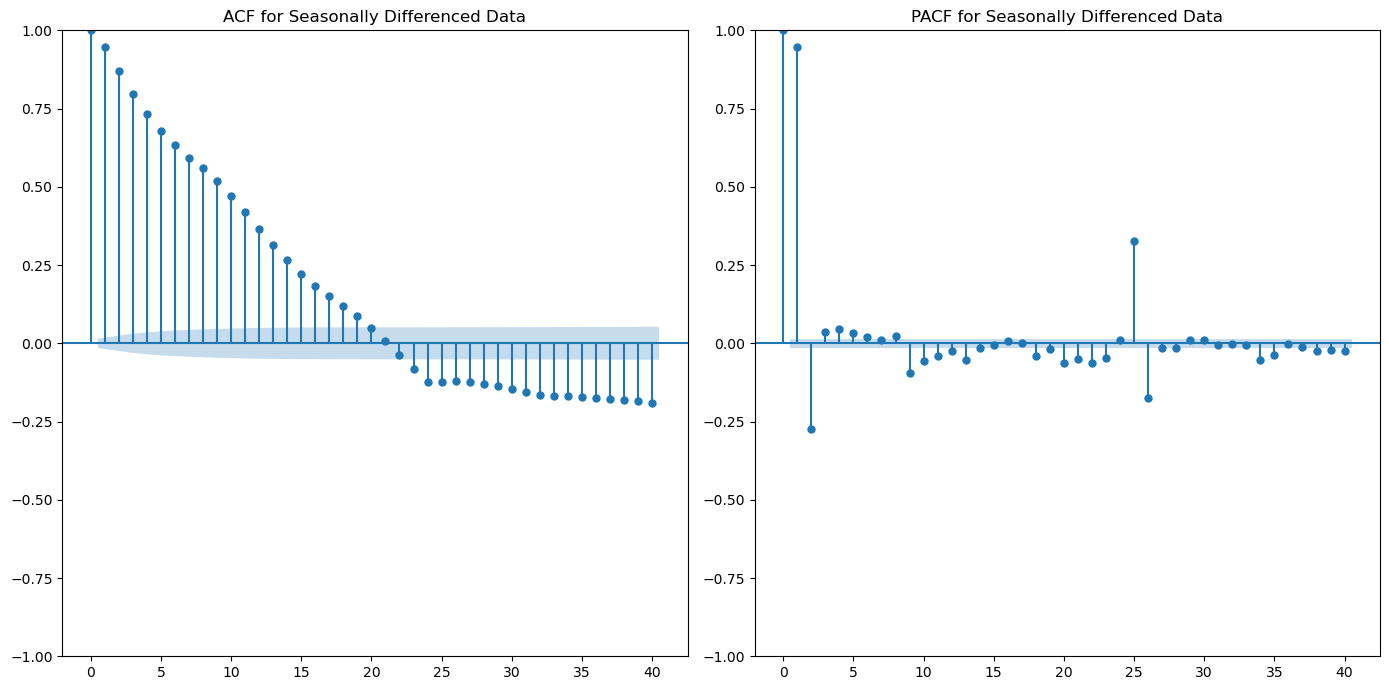

In [90]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for first-order differenced data
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(df_2023_diff1, ax=plt.gca(), lags=40, title='ACF for First-Order Differenced Data')
plt.subplot(122)
plot_pacf(df_2023_diff1, ax=plt.gca(), lags=40, title='PACF for First-Order Differenced Data')
plt.tight_layout()
plt.show()

# Plot ACF and PACF for seasonally differenced data
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(df_2023_diff_seasonal, ax=plt.gca(), lags=40, title='ACF for Seasonally Differenced Data')
plt.subplot(122)
plot_pacf(df_2023_diff_seasonal, ax=plt.gca(), lags=40, title='PACF for Seasonally Differenced Data')
plt.tight_layout()
plt.show()


# ARIMA model building 

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming 'df_2023' is your DataFrame and 'systemPrice' is the column with your time series data.
# Splitting the data into train and test sets (80% train, 20% test)

#train_size = int(len(df_2023) * 0.8)
#train, test = df_2023[0:train_size], df_2023[train_size:len(df_2023)]
#train, test = df_2023.iloc[:-24, :], df_2023.iloc[-24:, :]

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Split the data into training and testing sets
train = df[df.index.year < 2023]["systemPrice_stationary"]
#test = df[df.index.year == 2023]['systemPrice']

start_date = '2018-01-01'
end_date = '2022-01-31'

# Update the test set to include only the data for the specified one-week period
test = df[(df.index >= start_date) & (df.index <= end_date)]['systemPrice_stationary']

history = train.copy()  # History is the training data to which we'll append the test data iteratively
predictions = list()

# Walk-forward validation
for t in range(len(test)):
    # Fit the ARIMA model on the history
    model = ARIMA(history, order=(1,1,0))  # Change the order as per your model selection
    model_fit = model.fit()
    
    # Forecast the next time point
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    # Append the actual test observation to the history for the next loop
    # The fix is here: wrap yhat in pd.Series and provide the index from the test series
    history = history.append(pd.Series([test.iloc[t]], index=[test.index[t]]))

# Evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot forecasts against actual outcomes
plt.plot(test.values, label='Actual')
plt.plot(predictions, color='red', label='Forecast')
plt.title('ARIMA Day-Ahead Rolling Forecast')
plt.legend()
plt.show()


/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


/var/folders/cw/dgdk4x9j6fn07sqw2331qdhc0000gn/T/ipykernel_3715/3054225070.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = output[0]


AttributeError: 'Series' object has no attribute 'append'

In [19]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming df is your original DataFrame with 'systemPrice' column and DateTime index
# We will also assume that df is already defined and contains your data up to 2023

# Split the data into training and testing sets
train = df[df.index.year < 2023]['systemPrice']
test = df[(df.index >= '2023-01-01') & (df.index <= '2023-01-02')]['systemPrice']

history = train.copy()  # Start with the historical data
predictions = list()

# Walk-forward validation using only predictions to update history
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    
    # Forecast the next time point
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    # Append the predicted value to the history for the next loop
    history = history.append(pd.Series([yhat], index=[test.index[t]]))

# Calculate RMSE using the predictions and the actual test data
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, predictions, color='red', label='Forecast')
plt.title('ARIMA Forecast Using Only Predictions for Update')
plt.legend()
plt.show()


/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/var/folders/cw/dgdk4x9j6fn07sqw2331qdhc0000gn/T/ipykernel_3715/725123371.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = model_fit.fo

AttributeError: 'Series' object has no attribute 'append'